In [14]:
import json
import os
import torch
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import scipy
import torch.nn as nn
from torch.nn.functional import cross_entropy
from torchsummary import summary
from utils import scale_to_unit_range
from DataLoader import EuroSAT
from engine import train_one_epoch
from torchvision import datasets , transforms
from torchvision.transforms import ToTensor


In [15]:
# Hyperparameters
transform = transforms.Compose([
    ToTensor() , 
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) ,    
])
BATCH_SIZE = 8 
LR = 0.001
Epochs = 25 
device = 'cuda' if torch.cuda.is_available() else "cpu"
device


'cuda'

Dataset Prep

In [16]:
train_csv = pd.read_csv("EuroSAT/train.csv" , index_col = 0)
test_csv = pd.read_csv("EuroSAT/test.csv" , index_col = 0)
val_csv = pd.read_csv("EuroSAT/validation.csv" , index_col = 0)

train_csv = train_csv.sort_values(axis = 0 , by = ['ClassName'])
test_csv = test_csv.sort_values(axis = 0 , by = ['ClassName'])
val_csv = val_csv.sort_values(axis = 0 , by = ['ClassName'])

In [17]:
with open("EuroSAT/label_map.json" , 'r') as file:
    labels = json.load(file)
    class_names = list(labels.keys())
class_names 

['AnnualCrop',
 'Forest',
 'HerbaceousVegetation',
 'Highway',
 'Industrial',
 'Pasture',
 'PermanentCrop',
 'Residential',
 'River',
 'SeaLake']

In [18]:
train_set = []
test_set = []
val_set = []
sets = [train_csv , val_csv , test_csv]

for i , set in enumerate(sets):
    if i == 0:
        for index, row in set.iterrows():
            train_set.append(list(row))
    elif i == 2:
        for index, row in set.iterrows():
            test_set.append(list(row))
            
    else: 
        for index, row in set.iterrows():
            val_set.append(list(row))           

In [19]:
train = EuroSAT(parent_dir = "EuroSAT" , data = train_set , transform = transform)
val = EuroSAT(parent_dir = "EuroSAT" , data = val_set , transform = transform)
test = EuroSAT(parent_dir = "EuroSAT" , data = test_set , transform = transform)

len(train) , len(val) , len(test)

(18900, 5400, 2700)

In [20]:
train_loader = torch.utils.data.DataLoader(train , shuffle = True , batch_size=BATCH_SIZE)
val_loader = torch.utils.data.DataLoader(val , shuffle = True , batch_size=BATCH_SIZE)
test_loader = torch.utils.data.DataLoader(test, shuffle = False , batch_size=BATCH_SIZE)

len(train_loader) , len(val_loader)  , len(test_loader)

(2363, 675, 338)

Visualize some samples

In [21]:
train_iter = iter(train_loader)
first_batch = next(train_iter)
images , labels  = first_batch

images.shape , labels.shape

(torch.Size([8, 3, 64, 64]), torch.Size([8]))

In [22]:
formatted_images  = []
for image in images:
    image = image.permute(1 , 2 , 0)
    image = scale_to_unit_range(image)
    image = image.numpy()
    formatted_images.append(image)
    
images[0].shape , formatted_images[0].shape

(torch.Size([3, 64, 64]), (64, 64, 3))

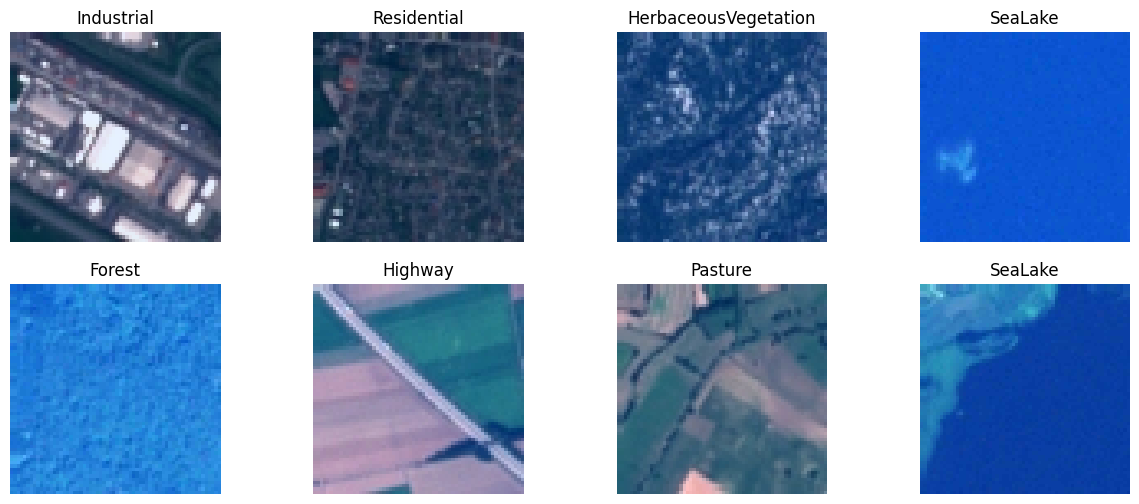

In [23]:
nrows = 2
ncolumns = 4
fig, axs = plt.subplots(nrows, ncolumns, figsize=(15, 6))

# Flatten the axs array to simplify accessing individual subplots
axs = axs.flatten()

for i in range(len(images)):
    ax = axs[i]  # Access the individual subplot
    ax.imshow(formatted_images[i])  # Display the image
    ax.set_title(class_names[labels[i]])  # Set the title to the class name of the image
    ax.axis('off')  # Hide the axis

plt.show()

NN using Pytorch library

In [27]:
class Class_Model(nn.Module):
    def __init__(self , num_classes = 10 , device = device ): # batch --> (BATCH_SIZE , 3 , 64 , 64 )
        super().__init__()
        self.conv2d_1 = nn.Conv2d(in_channels = 3 , out_channels= 16 , kernel_size=3) # (16 , 62 , 62)
        self.batch_norm_1 = nn.BatchNorm2d(16)
        self.act_1 = nn.ReLU()
        self.conv2d_2 = nn.Conv2d(in_channels = 16 ,out_channels = 64 , kernel_size = 5) # (64 , 58 , 58)
        self.batch_norm_2  = nn.BatchNorm2d(64)
        self.act_2 = nn.ReLU()
        self.flatten = nn.Flatten() # (64 , 58 ,58)
        self.fc1 = nn.Linear(64*58*58 , 16)
        self.fc2 = nn.Linear(16 , num_classes)
        self.act_3 = nn.LogSoftmax() ## nn.logsoftmax
        
    def forward(self, x):
        x = x.to(device) 
        conv2d_1 = self.conv2d_1(x)
        batch_norm1 = self.batch_norm_1(conv2d_1)
        act_1 = self.act_1(batch_norm1)
        conv2d_2 = self.conv2d_2(act_1)
        batch_norm_2 = self.batch_norm_2(conv2d_2)
        act_2 = self.act_2(batch_norm_2)
        flatten = self.flatten(act_2)
        fc1 = self.fc1(flatten)
        fc2 = self.fc2(fc1)
        logits = self.act_3(fc2)
        return logits

In [25]:
model = Class_Model().to(device)
optimizer = torch.optim.Adam(model.parameters() , lr = LR)
summary(model , input_size=( 3 , 64 , 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 62, 62]             448
       BatchNorm2d-2           [-1, 16, 62, 62]              32
              ReLU-3           [-1, 16, 62, 62]               0
            Conv2d-4           [-1, 64, 58, 58]          25,664
       BatchNorm2d-5           [-1, 64, 58, 58]             128
              ReLU-6           [-1, 64, 58, 58]               0
           Flatten-7               [-1, 215296]               0
            Linear-8                   [-1, 16]       3,444,752
            Linear-9                   [-1, 10]             170
       LogSoftmax-10                   [-1, 10]               0
Total params: 3,471,194
Trainable params: 3,471,194
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/backward pass size (MB): 7.98
Params size (MB): 13.24
Estima

/home/hasanmog/paper2code/lib/python3.10/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


In [28]:
losses = []
cross_entropy = torch.nn.CrossEntropyLoss()
for epoch in range(Epochs):
    
    print(f"Epoch number : {epoch + 1}")
    
    model.train(True)
    
    loss_per_epoch = train_one_epoch(model , training_loader=train_loader , optimizer=optimizer , loss_func = cross_entropy , device = device) 
    

Epoch number : 1
labels: tensor([3, 3, 3, 1, 2, 2, 7, 8], device='cuda:0')
pred_class :  tensor([0, 5, 7, 0, 5, 5, 5, 5], device='cuda:0')


/home/hasanmog/paper2code/lib/python3.10/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


RuntimeError: Expected floating point type for target with class probabilities, got Long